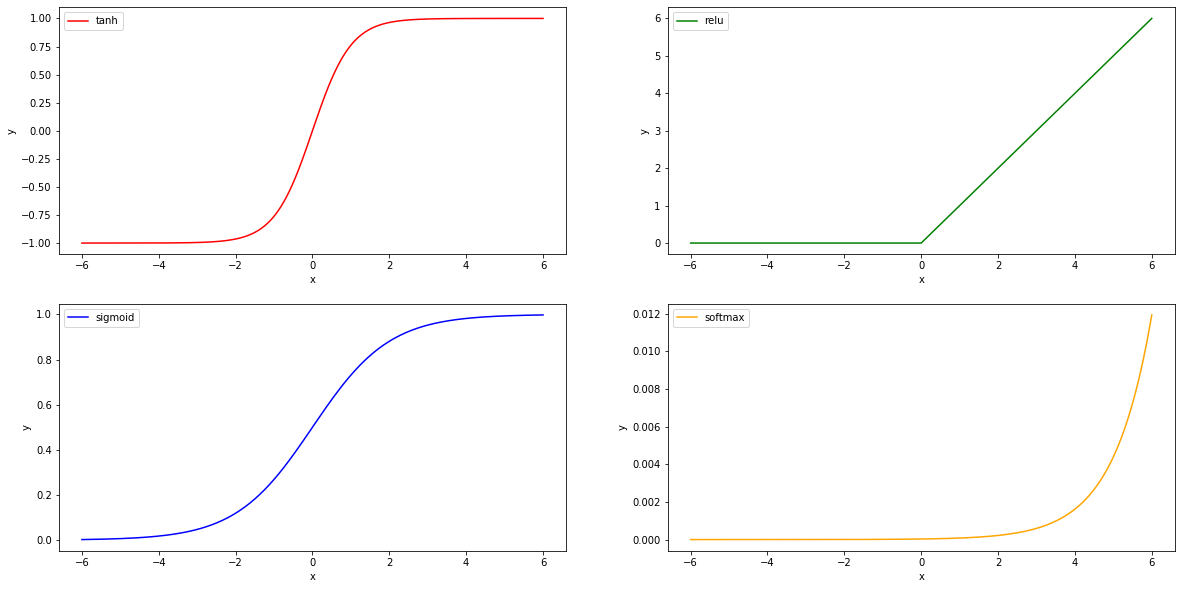

In [1]:
#PLOT MOST COMMON ACTIVATION FUNCTIONS
#PAGE 165-169
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def relu(x):
    return (x >= 0) * x

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def tanh(x):
    num = torch.exp(x) - torch.exp(-x)
    den = torch.exp(x) + torch.exp(-x)
    return num / den

def softmax(x):
    e_i = torch.exp(x)
    return e_i / torch.sum(e_i)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))


#tanh activation function
x = torch.linspace(-6, 6, 1000)
y_tanh = tanh(x)
axs[0, 0].plot(x, y_tanh, label='tanh', c='red')
axs[0, 0].legend()
    
#relu activation function
x = torch.linspace(-6, 6, 1000)
y_relu = relu(x)
axs[0, 1].plot(x, y_relu, label='relu', c='green')
axs[0, 1].legend()

#sigmoid activation function
x = torch.linspace(-6, 6, 1000)
y_sigmoid = sigmoid(x)
axs[1, 0].plot(x, y_sigmoid, label='sigmoid', c='blue')
axs[1, 0].legend()

#softmax activation function
x = torch.linspace(-6, 6, 1000)
y_softmax = softmax(x)
axs[1, 1].plot(x, y_softmax, label='softmax', c='orange')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='y')

In [3]:
#PAGE 174-175
#MNIST NETWORK WITH TANH AND SOFTMAX ACTIVATION FUNCTION
import torch
import torchvision
import torchvision.transforms as transforms
import sys

#get trainset and testset
train = torchvision.datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

#get images and labels of trainset and testset
train_loader = torch.utils.data.DataLoader(train, batch_size=len(train))
train_dataiter = iter(train_loader)
images, labels = train_dataiter.next()
test_loader = torch.utils.data.DataLoader(test, batch_size=len(test))
test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()

#map each digit to the right colunmn by the value 1 
one_hot_labels = torch.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels
one_hot_labels = torch.zeros((len(test_labels), 10))
for i, l in enumerate(test_labels):
    one_hot_labels[i][l] = 1
test_labels = one_hot_labels

#predict, compare and learn on trainset
tanh = lambda x: (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
tanh2deriv = lambda output: 1 - (output ** 2)
softmax = lambda x: torch.exp(x) / torch.sum(torch.exp(x))
batch_size, alpha, iterations, hidden_size, pixel_per_image, num_labels = (100, 0.00001, 300, 400, 28*28, 10)
images = images.view(len(images), pixel_per_image)
weights_0_1 = 0.2 * torch.rand(hidden_size, pixel_per_image) - 0.1 #size of weights_0_1 based on pytorch convention
weights_1_2 = 0.2 * torch.rand(num_labels, hidden_size) - 0.1 #size of weights_1_2 based on pytorch convention
for j in range(iterations):
    train_error, train_correct_cnt = (0.0, 0)
    for i in range(1000 // batch_size):
        batch_start = i * batch_size 
        batch_end = (i + 1) * batch_size

        layer_0 = images[batch_start:batch_end] #X0 cotains 100 inputs =  100 images
        layer_1 = tanh(layer_0 @ weights_0_1.T) #contains 100 'images'
        dropout_mask = torch.randint(0, 2, layer_1.size())
        layer_1 *= 2 * dropout_mask
        layer_2 = softmax(layer_1 @ weights_1_2.T)#contain 100 outputs

        train_error += torch.sum((layer_2 - labels[batch_start: batch_end]) ** 2)
        for k in range(batch_size):
            train_correct_cnt += int(torch.argmax(layer_2[k]) == torch.argmax(labels[batch_start + k]))
            layer_2_delta = (layer_2 - labels[batch_start: batch_end]) / (batch_size)
            layer_1_delta = (layer_2_delta.matmul(weights_1_2) * tanh2deriv(layer_1))
            layer_1_delta *= dropout_mask

            gradients_1_2 = layer_2_delta.T.matmul(layer_1) 
            weights_1_2 -= alpha * gradients_1_2
            gradients_0_1 = layer_1_delta.T.matmul(layer_0) 
            weights_0_1 -= alpha * gradients_0_1
    sys.stdout.write(f'\r Epoch: {j} Train Error: {train_error/1000:.2f} Train Accuracy: {train_correct_cnt/1000:.2f} ')
    
    #Evaluate on testset
    test_images = test_images.view(len(test_images), pixel_per_image)    
    test_error, test_correct_cnt = (0.0, 0)
    for i in range(len(test_images)):
        layer_0 = test_images[i].view(1, -1) #X0 cotains 100 inputs =  100 images
        layer_1 = tanh(layer_0.matmul(weights_0_1.T)).view(1, -1)#contains 100 'images
        layer_2 = softmax(layer_1.matmul(weights_1_2.T).view(1, -1)) #contain 100 outputs
        test_error += torch.sum((layer_2 - test_labels[i]) ** 2)
        test_correct_cnt += int(torch.argmax(layer_2) == torch.argmax(test_labels[i]))
    sys.stdout.write(f'Test Error: {test_error/len(test_images):.2f} Test Accuracy: {test_correct_cnt/len(test_images):.2f}')
    print()

 Epoch: 0 Train Error: 1.00 Train Accuracy: 0.07 Test Error: 0.93 Test Accuracy: 0.06
 Epoch: 1 Train Error: 1.00 Train Accuracy: 0.09 Test Error: 0.93 Test Accuracy: 0.07
 Epoch: 2 Train Error: 1.00 Train Accuracy: 0.07 Test Error: 0.93 Test Accuracy: 0.07
 Epoch: 3 Train Error: 1.00 Train Accuracy: 0.09 Test Error: 0.93 Test Accuracy: 0.07
 Epoch: 4 Train Error: 1.00 Train Accuracy: 0.09 Test Error: 0.92 Test Accuracy: 0.07
 Epoch: 5 Train Error: 1.00 Train Accuracy: 0.08 Test Error: 0.92 Test Accuracy: 0.08
 Epoch: 6 Train Error: 1.00 Train Accuracy: 0.10 Test Error: 0.92 Test Accuracy: 0.08
 Epoch: 7 Train Error: 1.00 Train Accuracy: 0.12 Test Error: 0.92 Test Accuracy: 0.09
 Epoch: 8 Train Error: 1.00 Train Accuracy: 0.11 Test Error: 0.92 Test Accuracy: 0.09
 Epoch: 9 Train Error: 1.00 Train Accuracy: 0.10 Test Error: 0.91 Test Accuracy: 0.09
 Epoch: 10 Train Error: 1.00 Train Accuracy: 0.11 Test Error: 0.91 Test Accuracy: 0.10
 Epoch: 11 Train Error: 1.00 Train Accuracy: 0.10 Tes

 Epoch: 94 Train Error: 0.99 Train Accuracy: 0.49 Test Error: 0.68 Test Accuracy: 0.55
 Epoch: 95 Train Error: 0.99 Train Accuracy: 0.50 Test Error: 0.68 Test Accuracy: 0.55
 Epoch: 96 Train Error: 0.99 Train Accuracy: 0.49 Test Error: 0.68 Test Accuracy: 0.55
 Epoch: 97 Train Error: 0.99 Train Accuracy: 0.51 Test Error: 0.67 Test Accuracy: 0.55
 Epoch: 98 Train Error: 0.99 Train Accuracy: 0.51 Test Error: 0.67 Test Accuracy: 0.56
 Epoch: 99 Train Error: 0.99 Train Accuracy: 0.50 Test Error: 0.67 Test Accuracy: 0.56
 Epoch: 100 Train Error: 0.99 Train Accuracy: 0.51 Test Error: 0.67 Test Accuracy: 0.56
 Epoch: 101 Train Error: 0.99 Train Accuracy: 0.51 Test Error: 0.66 Test Accuracy: 0.56
 Epoch: 102 Train Error: 0.99 Train Accuracy: 0.52 Test Error: 0.66 Test Accuracy: 0.56
 Epoch: 103 Train Error: 0.99 Train Accuracy: 0.52 Test Error: 0.66 Test Accuracy: 0.56
 Epoch: 104 Train Error: 0.99 Train Accuracy: 0.53 Test Error: 0.66 Test Accuracy: 0.57
 Epoch: 105 Train Error: 0.99 Train Ac

 Epoch: 187 Train Error: 0.99 Train Accuracy: 0.62 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 188 Train Error: 0.99 Train Accuracy: 0.62 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 189 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 190 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 191 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 192 Train Error: 0.99 Train Accuracy: 0.63 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 193 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.52 Test Accuracy: 0.64
 Epoch: 194 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.51 Test Accuracy: 0.64
 Epoch: 195 Train Error: 0.99 Train Accuracy: 0.65 Test Error: 0.51 Test Accuracy: 0.64
 Epoch: 196 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.51 Test Accuracy: 0.64
 Epoch: 197 Train Error: 0.99 Train Accuracy: 0.64 Test Error: 0.51 Test Accuracy: 0.64
 Epoch: 198 Train Error: 0.99 Tr

 Epoch: 280 Train Error: 0.99 Train Accuracy: 0.67 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 281 Train Error: 0.99 Train Accuracy: 0.65 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 282 Train Error: 0.99 Train Accuracy: 0.68 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 283 Train Error: 0.99 Train Accuracy: 0.66 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 284 Train Error: 0.99 Train Accuracy: 0.66 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 285 Train Error: 0.99 Train Accuracy: 0.66 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 286 Train Error: 0.99 Train Accuracy: 0.68 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 287 Train Error: 0.99 Train Accuracy: 0.67 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 288 Train Error: 0.99 Train Accuracy: 0.67 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 289 Train Error: 0.99 Train Accuracy: 0.68 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 290 Train Error: 0.99 Train Accuracy: 0.67 Test Error: 0.47 Test Accuracy: 0.65
 Epoch: 291 Train Error: 0.99 Tr